In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from tensorflow import keras 
import time
import matplotlib.pyplot as plt

<b>LOADING AND PREPROCESSING THE DATASET</b>

In [2]:
#loading and preprocessing the dataset
batch_size = 32
image_size = (28,28)
root_dir = 'D:\\Documents\\DATA_SET_FOR_RELEASE\\renamed\\all_train'
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(root_dir,
  image_size=image_size,
  batch_size=batch_size,
  label_mode=None,
  validation_split=0.1,
  subset = 'both',
  seed = 45)


 
normalization_layer = layers.Rescaling(scale= 1./255) 
 
normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))
normalized_val_ds = val_ds.map(lambda x: normalization_layer(x))

Found 540 files belonging to 1 classes.
Using 486 files for training.
Using 54 files for validation.


  <b>DEFINE SAMPLING TECHNIQUE FOR THE LATENT SPACE</b>

In [3]:
#sampling_reparameterization function--- Function for generating samples
def sampling_reparameterization(distribution_params):
    mean, log_var = distribution_params
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mean), mean=0., stddev=1.)
    z = mean + tf.keras.backend.exp(log_var / 2) * epsilon
    
    return z

In [4]:
#the sampling network
latent_dim = 10 #dimension of the latent space

def sampling(input_1,input_2):
    mean = keras.Input(shape=input_1, name='input_layer1')
    log_var = keras.Input(shape=input_2, name='input_layer2')
    out = layers.Lambda(sampling_reparameterization, name='encoder_output')([mean, log_var])
    enc_2 = tf.keras.Model([mean,log_var], out,  name="Encoder_2")
    
    return enc_2
sampler = sampling(latent_dim, latent_dim)

 <b>DEFINE LOSS FUNCTION AND OPTIMIZER FOR TRAINING</b>

In [79]:
#Define the initial learning rate and the decay rate
initial_learning_rate = 0.0008
decay_steps = 200
decay_rate = 0.7
staircase = True

# Create the learning rate schedule
learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps, decay_rate, staircase=staircase)

# Define the optimizer
optimizer_1 = tf.optimizers.Adam(learning_rate=learning_rate_fn)
optimizer_2 = tf.optimizers.Adam(learning_rate=learning_rate_fn)

#Define scaling factor for loss functions
beta = 660
 
def mse_loss(y_true, y_pred):
    r_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred), axis = [1,2,3])
    return r_loss
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * tf.keras.backend.sum(1 + log_var - tf.keras.backend.square(mean) - tf.keras.backend.exp(log_var), axis = 1)
    return kl_loss
 
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    KL_loss = kl_loss(mean, log_var)
    training_loss = (beta*r_loss) + KL_loss
    
    return training_loss

 <b>BUILDING THE ENCODER</b>

In [80]:

def encoder(input_encoder):
     
     
    inputs = keras.Input(shape=input_encoder, name='input_layer')
     
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
    
    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
  
 
    # # Final Block
    flatten = layers.Flatten(name = 'Flatten_1')(x)
    flatten = layers.Dense(32, name='Flatten_2')(flatten)
    flatten = layers.Dense(16, name='Flatten_3')(flatten)
    mean = layers.Dense(latent_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_dim, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

    

    
enc = encoder((*image_size,3))
enc.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 14, 14, 32)   896         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 14, 14, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 14, 14, 32)   0           ['bn_1[0][0]']                   
                                                                                            

 <b>BUILDING THE DECODER</b>

In [81]:
#build the decoder
def decoder(input_decoder):
     
    inputs = keras.Input(shape=input_decoder, name='input_layer')
  
    x = layers.Dense(100, name='dense_1')(inputs)
    x = layers.LeakyReLU(name='lrelu_A')(x)

    x = layers.Dense(600, name='dense_2')(x)
    x = layers.LeakyReLU(name='lrelu_B')(x)

    x = layers.Dense(3136, name='dense_3')(x)
    x = layers.LeakyReLU(name='lrelu_C')(x)
    x = layers.Reshape((7,7,64), name='Reshape')(x)
     
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_A')(x)
    x = layers.LeakyReLU(name='lrelu_D')(x)
    
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_B')(x)
    x = layers.LeakyReLU(name='lrelu_E')(x)
  
  
    # Block-3
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_C')(x)
    x = layers.LeakyReLU(name='lrelu_F')(x)
       
    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model
    print(dec.summary())
    
dec = decoder((latent_dim,))
dec.summary()


Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
 lrelu_A (LeakyReLU)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 600)               60600     
                                                                 
 lrelu_B (LeakyReLU)         (None, 600)               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              1884736   
                                                                 
 lrelu_C (LeakyReLU)         (None, 3136)              0   

 <b>DEFINE CUSTOM TRAINING LOOP</b>

In [82]:
@tf.function
def train_step(train_images):
 
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
       
       
        mean, log_var = enc(train_images, training=True)
        latent = sampler([mean, log_var])
        generated_images = dec(latent, training=True)
        loss = vae_loss(train_images, generated_images, mean, log_var)
        MSE =  mse_loss(train_images, generated_images)
        KLE = kl_loss(mean, log_var)

         
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
     
    optimizer_1.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer_2.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss,MSE,KLE


def val_step(val_images):
  mean, log_var = enc(val_images)
  latent = sampler([mean, log_var])
  generated_images_val = dec(latent)
  val_loss = mse_loss(val_images, generated_images_val)

  return val_loss
        

In [83]:
training_loss_list = []
mse_loss_list = []
kl_loss_list = []
val_mse_list = []


def train(train_dataset,val_dataset = None, epochs = 50):
  for epoch in range(epochs):
    epoch_loss = []
    epoch_mse_loss = []
    epoch_kl_loss = []
    epoch_val_loss=[]
    
    start = time.time()
    for image_batch in train_dataset:
      loss,MSE,KLE = train_step(image_batch)
      epoch_loss.append(np.mean(loss))
      epoch_mse_loss.append(np.mean(MSE))
      epoch_kl_loss.append(np.mean(KLE))

    
    if val_dataset:
      for image_batch in val_dataset:
        val_mse =np.mean(val_step(image_batch))
        epoch_val_loss.append(val_mse)
      epoch_val_loss = np.mean(epoch_val_loss)


    
    epoch_loss = np.mean(epoch_loss)
    epoch_mse_loss = np.mean(epoch_mse_loss)
    epoch_kl_loss = np.mean(epoch_kl_loss)
    
    training_loss_list.append(epoch_loss)
    mse_loss_list.append(epoch_mse_loss)
    kl_loss_list.append(epoch_kl_loss)
    val_mse_list.append(epoch_val_loss)
    
    print(f'epoch: {epoch+1} || Training Loss:{epoch_loss:.4f} || MSE:{epoch_mse_loss:.4f} || KL_Loss: {epoch_kl_loss:.4f} || Val_MSE:{epoch_val_loss:.4f} || time {time.time()-start:.4f}')
   
  
#train for 120 epochs 
train(normalized_train_ds, val_dataset = normalized_val_ds, epochs = 60)

epoch: 1 || Training Loss:32.0014 || MSE:0.0391 || KL_Loss: 6.2185 || Val_MSE:0.0541 || time 14.7531
epoch: 2 || Training Loss:16.0945 || MSE:0.0203 || KL_Loss: 2.6836 || Val_MSE:0.0480 || time 4.7398
epoch: 3 || Training Loss:13.7617 || MSE:0.0177 || KL_Loss: 2.0999 || Val_MSE:0.0485 || time 3.9633
epoch: 4 || Training Loss:13.6411 || MSE:0.0179 || KL_Loss: 1.8295 || Val_MSE:0.0453 || time 3.9582
epoch: 5 || Training Loss:12.8834 || MSE:0.0164 || KL_Loss: 2.0407 || Val_MSE:0.0420 || time 3.6615
epoch: 6 || Training Loss:13.1650 || MSE:0.0169 || KL_Loss: 2.0384 || Val_MSE:0.0421 || time 4.0380
epoch: 7 || Training Loss:13.0258 || MSE:0.0164 || KL_Loss: 2.1820 || Val_MSE:0.0390 || time 4.4551
epoch: 8 || Training Loss:12.6340 || MSE:0.0163 || KL_Loss: 1.8608 || Val_MSE:0.0378 || time 4.0496
epoch: 9 || Training Loss:11.4510 || MSE:0.0144 || KL_Loss: 1.9382 || Val_MSE:0.0395 || time 5.5638
epoch: 10 || Training Loss:11.7037 || MSE:0.0148 || KL_Loss: 1.9381 || Val_MSE:0.0373 || time 4.080

<b>VISUALIZE PERFORMANCE OF THE VAE</b>

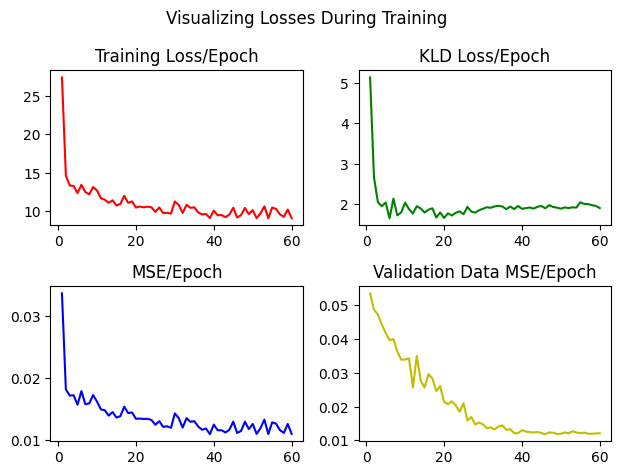

In [78]:
num_of_epochs = 60
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(1,num_of_epochs+1), training_loss_list,'r')
axs[0, 0].set_title("Training Loss/Epoch")
axs[1, 0].plot(range(1,num_of_epochs+1), mse_loss_list,'b')
axs[1, 0].set_title("MSE/Epoch")

axs[0, 1].plot(range(1,num_of_epochs+1), kl_loss_list,'g')
axs[0, 1].set_title("KLD Loss/Epoch")
axs[1, 1].plot(range(1,num_of_epochs+1), val_mse_list,'y')
axs[1, 1].set_title("Validation Data MSE/Epoch")
fig.suptitle('Visualizing Losses During Training')
fig.tight_layout();

1/1 [==============================] - 1s 589ms/step


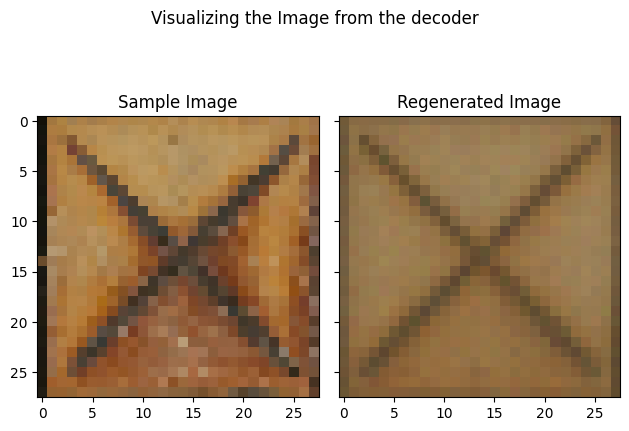

In [67]:
sample_img_1 = 'D:\\Documents\\DATA_SET_FOR_RELEASE\\renamed\\all_train\\5\\I359_Steel---HHA_abrasive-blasted_zirconium-pretreatment_MIL-DTL-53022_MIL-DTL-53039.jpg'
img_1 = plt.imread(sample_img_1)

sample = tf.keras.Sequential([layers.Resizing(28,28, input_shape = (512,512,3)),
                              layers.Rescaling(scale= 1./255)])
                             
sample_1 = sample(np.expand_dims(img_1, axis = 0)).numpy()

m, v = enc.predict(sample_1)
latent = sampler([m,v])

reconst = dec.predict(latent)
reconst = np.reshape(reconst,(28,28,3))

fig, (axs_1,axs_2) = plt.subplots(1, 2, sharey='row')
axs_1.imshow(np.squeeze(sample_1))
axs_1.set_title("Sample Image")

axs_2.imshow(reconst)
axs_2.set_title("Regenerated Image")
fig.suptitle('Visualizing the Image from the decoder')
fig.tight_layout();

<b>TRAINING THE CLASSIFIERS</b>

In [28]:
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
from sklearn.metrics import accuracy_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost

import warnings


warnings.filterwarnings('ignore')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

<b>PREPROCESSING THE DATASET FOR THE CLASSIFIERS</b>

In [29]:

root_Dir = 'D:\\Documents\\DATA_SET_FOR_RELEASE\\renamed\\all_train'

#Create an empty dataframe
df = pd.DataFrame(columns=['image', 'label'])
#Iterate over the sub directories within the root directory
for dirs, subdirs, files in os.walk(root_Dir):
  for file in files:
    file_path = os.path.join(dirs, file)
    
    #load the image
    with Image.open(file_path) as img:
      #convert image to numpy array
      img_array = np.array(img)
      #Extract the label
      label = os.path.basename(dirs)
      #Add the image and label to the dataframe
      df = df.append({'image':img_array, 'label':label}, ignore_index = True)
# df = df.sample(frac = 1).reset_index(drop = True)
df.head(10)

,image,label
0,"[[[250, 255, 246], [239, 245, 235], [246, 247,...",5
1,"[[[244, 255, 241], [243, 249, 235], [247, 241,...",5
2,"[[[255, 249, 231], [248, 240, 221], [255, 243,...",5
3,"[[[253, 255, 247], [241, 247, 237], [244, 250,...",5
4,"[[[255, 242, 222], [246, 229, 211], [244, 230,...",5
5,"[[[255, 255, 250], [18, 17, 12], [18, 17, 13],...",5
6,"[[[255, 252, 249], [250, 247, 242], [255, 250,...",5
7,"[[[255, 255, 246], [243, 239, 230], [245, 238,...",5
8,"[[[255, 249, 232], [251, 244, 228], [247, 245,...",5
9,"[[[249, 255, 238], [242, 246, 229], [244, 240,...",5


In [30]:
y = df['label']
X = df['image'].values
X = np.stack(X)

preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(tf.keras.Input(shape=(512,512,3)))
preprocessing_model.add(tf.keras.layers.Resizing(28,28))
preprocessing_model.add(tf.keras.layers.Rescaling(scale= 1./255))
X1 = preprocessing_model.predict(X)

a,b = enc.predict(X1, batch_size=batch_size)


17/17 [==============================] - 0s 21ms/step


<b>DECISION TREE CLASSIFIER</b>

In [31]:
LE = LabelEncoder()
X_train, X_test, y_train_raw, y_test_raw = train_test_split(a, y, test_size=0.2, random_state=42)
y_train = LE.fit_transform(y_train_raw)
y_test = LE.transform(y_test_raw)
DT = DecisionTreeClassifier(max_leaf_nodes=5)
DT.fit(X_train, y_train)
DT_y_pred = DT.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test, DT_y_pred))

Accuracy Score:  0.5555555555555556


<b>RANDOM FOREST CLASSIFIER</b>

In [16]:
RF_search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 10), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto']), 
        "min_samples_leaf": Integer(2, 8),
        "min_samples_split": Integer(2, 5),
        "n_estimators": Integer(350, 500)
    }
RF = RandomForestClassifier()
RF_bayes_search = BayesSearchCV(RF, RF_search_space, n_iter=50, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)
RF_bayes_search.fit(X_train, y_train) 
RF_y_pred = RF_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, RF_y_pred))


Accuracy Score:  0.5555555555555556


<b>SUPPORT VECTOR CLASSIFIER</b>

In [ ]:
SVM = SVC()
SVM_search_space = {'C':Real(0.01,2),
                    'kernel':Categorical(['linear','rbf'])}
SVM_bayes_search = BayesSearchCV(SVM, SVM_search_space, n_iter = 50, n_jobs = -1, cv = cv,
                                scoring = 'accuracy')
SVM_bayes_search.fit(X_train, y_train)

SVM_y_pred = SVM_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, SVM_y_pred))

<b>NEAREST NEIGHBORS CLASSIFIER</b>

In [ ]:

KNN = KNeighborsClassifier()
KNN_search_space = {'n_neighbors':Integer(37,39),
                  }
KNN_bayes_search = BayesSearchCV(KNN, KNN_search_space, n_iter = 50, n_jobs = -1, cv = cv, 
                                scoring ='accuracy')
KNN_bayes_search.fit(X_train, y_train)
KNN_y_pred = KNN_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, KNN_y_pred))

<b>LOGISTIC REGRESSION CLASSIFIER</b>

In [ ]:

LR = LogisticRegression()
LR_search_space = {'C':Real(0.01,1),
                    'penalty':Categorical(['l2','none']),
                    'max_iter':Integer(50,150),
                    'l1_ratio': Real(0,1)}
LR_bayes_search = BayesSearchCV(LR, LR_search_space, n_iter = 50, n_jobs = -1, cv = 5,
                                scoring = 'accuracy')
LR_bayes_search.fit(X_train, y_train)

LR_y_pred = LR_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test,LR_y_pred))


<b>EXTREME GRADIENT BOOST CLASSIFIER</b>

In [32]:

LE = LabelEncoder()
xgb_y_train = LE.fit_transform(y_train)
xgb_y_test = LE.transform(y_test)
XGB = xgboost.XGBClassifier()

XGB_search_space = {
                   'max_depth':Integer(3,10),
                    'n_estimators':Integer(50,800)
                   }
XGB_bayes_search = BayesSearchCV(XGB, XGB_search_space, n_iter = 50, n_jobs = -1, cv = 5,
                                scoring = 'accuracy')
XGB_bayes_search.fit(X_train,y_train)

XGB_y_pred  = XGB_bayes_search.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test,XGB_y_pred ))

Accuracy Score:  0.5833333333333334


<b>VOTING CLASSIFIER</b>

In [ ]:

RF_params = dict(RF_bayes_search.best_params_)
KNN_params = dict(KNN_bayes_search.best_params_)
SVM_params = dict(SVM_bayes_search.best_params_)
LR_params = dict(LR_bayes_search.best_params_)
XGB_params = dict(XGB_bayes_search.best_params_)


estimator = []

estimator.append(('RF', RandomForestClassifier(bootstrap=RF_params['bootstrap'],
                                                max_depth=RF_params['max_depth'],
                                                max_features=RF_params['max_features'],
                                                min_samples_leaf = RF_params['min_samples_leaf'],
                                                min_samples_split=RF_params['min_samples_split'],
                                                n_estimators =  RF_params['n_estimators'])))

estimator.append(('SVM', SVC(C=SVM_params['C'],
                             kernel=SVM_params['kernel'],
                            probability=True)))

estimator.append(('KNN', KNeighborsClassifier(n_neighbors=KNN_params['n_neighbors'])))

estimator.append(('LR', LogisticRegression(C=LR_params['C'],
                                           l1_ratio=LR_params['l1_ratio'],
                                           max_iter=LR_params['max_iter'],
                                           penalty = LR_params['penalty'])))
estimator.append(('XGB', xgboost.XGBClassifier(max_depth=XGB_params['max_depth'],
                                              n_estimators = XGB_params['n_estimators'],
                                              objective='multi: softprob')))

VC_hard = VotingClassifier(estimators = estimator, voting = 'hard')
VC_soft = VotingClassifier(estimators = estimator, voting = 'soft')

VC_hard.fit(X_train, y_train)
VC_soft.fit(X_train, y_train)

VC_hard_pred = VC_hard.predict(X_test)
VC_soft_pred = VC_soft.predict(X_test)

print(f'VC_hard_accuracy: {accuracy_score(y_test,VC_hard_pred)}')
print(f'VC_soft_accuracy: {accuracy_score(y_test,VC_soft_pred)}')

<b>RESULT FROM HYPER PARAMETER SEARCH</b>

In [ ]:
print('RF Hyper-parameters:', dict(RF_bayes_search.best_params_))
print('\n\nSVM Hyper-parameters:', dict(SVM_bayes_search.best_params_))
print('\n\nKNN Hyper-parameters:', dict(KNN_bayes_search.best_params_))
print('\n\nLR Hyper-parameters:', dict(LR_bayes_search.best_params_))
print('\n\nXGB Hyper-parameters:', dict(XGB_bayes_search.best_params_))